# Text classification with an RNN

This short text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow_datasets as tfds
import tensorflow as tf

Import `matplotlib` and create a helper function to plot graphs:

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

In [0]:
### download the dataset using TFDS (https://www.tensorflow.org/datasets). The dataset comes with an inbuilt subword tokenizer. 


dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteX78C0Q/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteX78C0Q/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteX78C0Q/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


As this is a subwords tokenizer, it can be passed any string and the tokenizer will tokenize it.

In [0]:
tokenizer = info.features['text'].encoder

In [0]:
# print the Vocabulary size of the dataset

print ('Vocabulary size: {}'.format(tokenizer.vocab_size))

Vocabulary size: 8185


In [0]:
sample_string = 'ISS is cool.'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [8002, 3912, 7961, 9, 2724, 7975]
The original string: ISS is cool.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [0]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

8002 ----> I
3912 ----> SS
7961 ---->  
9 ----> is 
2724 ----> cool
7975 ----> .


Let us try to visualize our training data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Let us print a trianing example.

In [0]:
train_examples_batch, train_labels_batch = next(iter(train_dataset.batch(1)))
train_examples_batch

Let us also print the corresponding label

In [0]:
train_labels_batch

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
# batch and suffle the data

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## Create the model

Build a tf.keras.Sequential model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compile the Keras model to configure the training process:

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train the model

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10


W0705 12:00:36.977246 140624246093696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


391/391 [==============================] - 315s 807ms/step - loss: 0.4878 - accuracy: 0.7613 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 125s 321ms/step - loss: 0.3218 - accuracy: 0.8763 - val_loss: 0.3926 - val_accuracy: 0.8370
Epoch 3/10
391/391 [==============================] - 109s 278ms/step - loss: 0.2648 - accuracy: 0.9023 - val_loss: 0.4066 - val_accuracy: 0.8337
Epoch 4/10
391/391 [==============================] - 95s 244ms/step - loss: 0.2474 - accuracy: 0.9089 - val_loss: 0.4280 - val_accuracy: 0.8128
Epoch 5/10
391/391 [==============================] - 92s 236ms/step - loss: 0.2009 - accuracy: 0.9276 - val_loss: 0.4290 - val_accuracy: 0.8374
Epoch 6/10
391/391 [==============================] - 87s 222ms/step - loss: 0.2054 - accuracy: 0.9254 - val_loss: 0.4653 - val_accuracy: 0.8104
Epoch 7/10
391/391 [==============================] - 85s 218ms/step - loss: 0.2773 - accuracy: 0.8871 - val_loss: 0.4797 - val_ac

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 25s 65ms/step - loss: 0.5706 - accuracy: 0.8224Test Loss: 0.5706017750989446
Test Accuracy: 0.8224400281906128


The above model does not mask the padding applied to the sequences. This can lead to skewness if we train on padded sequences and test on un-padded sequences. Ideally the model would learn to ignore the padding, but as you can see below it does have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sentence, pad):
  tokenized_sample_pred_text = tokenizer.encode(sample_pred_text)

  if pad:
    tokenized_sample_pred_text = pad_to_size(tokenized_sample_pred_text, 64)

  predictions = model.predict(tf.expand_dims(tokenized_sample_pred_text, 0))

  return (predictions)

In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.89008105]]


In [0]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.68614584]]


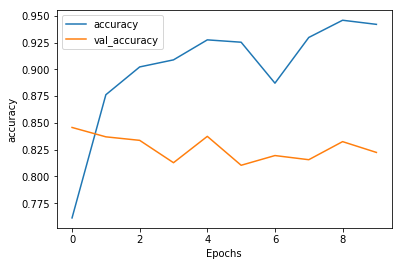

In [0]:
plot_graphs(history, 'accuracy')

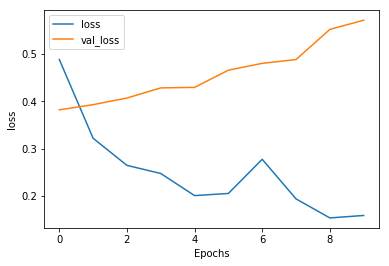

In [0]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [0]:
# redefine the model by stacking two or more LSTM layers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10


W0705 12:32:59.706593 140053941434240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


391/391 [==============================] - 530s 1s/step - loss: 0.5263 - accuracy: 0.7349 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 209s 535ms/step - loss: 0.4060 - accuracy: 0.8276 - val_loss: 0.4964 - val_accuracy: 0.7890
Epoch 3/10
391/391 [==============================] - 165s 423ms/step - loss: 0.3393 - accuracy: 0.8636 - val_loss: 0.4773 - val_accuracy: 0.7863
Epoch 4/10
391/391 [==============================] - 153s 392ms/step - loss: 0.2962 - accuracy: 0.8818 - val_loss: 0.4484 - val_accuracy: 0.8258
Epoch 5/10
391/391 [==============================] - 150s 384ms/step - loss: 0.2241 - accuracy: 0.9135 - val_loss: 0.4624 - val_accuracy: 0.8174
Epoch 6/10
391/391 [==============================] - 142s 363ms/step - loss: 0.1944 - accuracy: 0.9273 - val_loss: 0.5053 - val_accuracy: 0.8225
Epoch 7/10
391/391 [==============================] - 140s 359ms/step - loss: 0.1732 - accuracy: 0.9372 - val_loss: 0.5808 - val_a

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 40s 102ms/step - loss: 0.6397 - accuracy: 0.7974Test Loss: 0.6396676265370206
Test Accuracy: 0.7974399924278259


In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.03851678]]


In [0]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.05152063]]


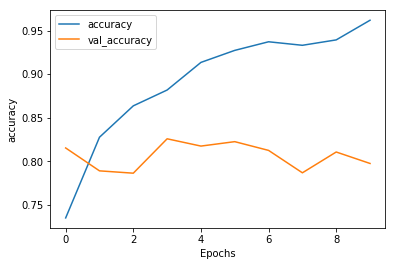

In [0]:
plot_graphs(history, 'accuracy')

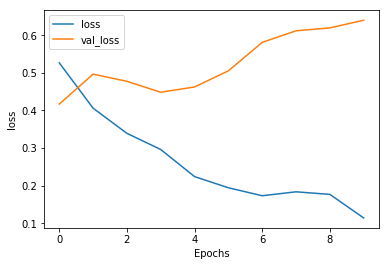

In [0]:
plot_graphs(history, 'loss')